# House Prices Prediction
## Import data and packages

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

In [3]:
df_train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
print('train shape:', df_train.shape)
print('test shape:', df_test.shape)
df_train.head()

train shape: (1460, 81)
test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# train y summary
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

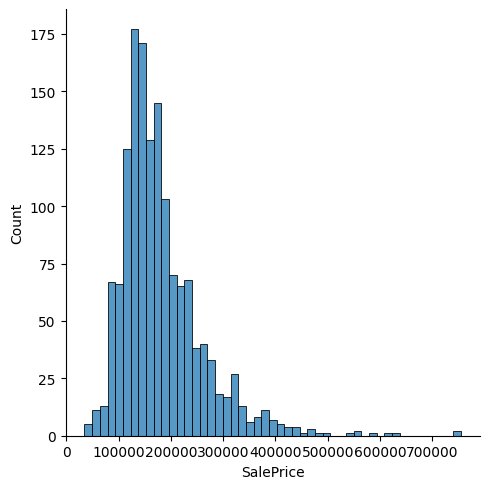

In [6]:
# train y histogram
sns.displot(df_train['SalePrice']);

## Feature Engineering

In [7]:
# combine train and test to do feture engineering later
df_all = pd.concat([df_train, df_test])

### Check Missing Values

In [8]:
#missing data
null_count = df_all.isnull().sum().sort_values(ascending=False)
ratio = (df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False)
missing_columns_count = pd.concat([null_count, ratio], axis=1, keys=['Total', 'Ratio'])
missing_columns_count.head(40)

,Total,Ratio
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
MasVnrType,1766,0.605002
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471


### null values
- SalePrice is the target value, keep it in dataframe
- Delet columns that are mostly empty: PoolQC, MiscFeature, Alley, Fence, FireplaceQu, and LotFrontage
- Garage columns are similar to each other, the null rows have no garage
- Basement columns are similar to each other, the null rows have no basement
- MasVnrArea (Masonry veneer area in square feet) is null if no Masonry veneer area

In [9]:
# delete columns mostly null
df_all = df_all.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                      'MasVnrType', 'FireplaceQu', 'LotFrontage'], axis=1)

# replace Garage columns null values
garage_cols = ['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']
df_all[garage_cols] = df_all[garage_cols].fillna(0)

# replace basement columns null values
basement_cols = ['BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
df_all[basement_cols] = df_all[basement_cols].fillna(0)

# replace MasVnrArea null values
df_all['MasVnrArea'] = df_all['MasVnrArea'].fillna(0)


### check specific missing values
- if nessosary, delete the rows

In [10]:
print(df_all.loc[df_all['MSZoning'].isnull()].index)
print(df_all['MSZoning'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['Functional'].isnull()].index)
print(df_all['Functional'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['Electrical'].isnull()].index)
print(df_all['Electrical'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['Utilities'].isnull()].index)
print(df_all['Utilities'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['BsmtHalfBath'].isnull()].index)
print(df_all['BsmtHalfBath'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['TotalBsmtSF'].isnull()].index)
print(df_all['TotalBsmtSF'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['BsmtUnfSF'].isnull()].index)
print(df_all['BsmtUnfSF'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['KitchenQual'].isnull()].index)
print(df_all['KitchenQual'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['BsmtFinSF2'].isnull()].index)
print(df_all['BsmtFinSF2'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['BsmtFinSF1'].isnull()].index)
print(df_all['BsmtFinSF1'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['SaleType'].isnull()].index)
print(df_all['SaleType'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['GarageCars'].isnull()].index)
print(df_all['GarageCars'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['Exterior2nd'].isnull()].index)
print(df_all['Exterior2nd'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['Exterior1st'].isnull()].index)
print(df_all['Exterior1st'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['GarageArea'].isnull()].index)
print(df_all['GarageArea'].describe())
print('------------------------------------------')
print(df_all.loc[df_all['BsmtFullBath'].isnull()].index)
print(df_all['BsmtFullBath'].describe())


Index([455, 756, 790, 1444], dtype='int64')
count     2915
unique       5
top         RL
freq      2265
Name: MSZoning, dtype: object
------------------------------------------
Index([756, 1013], dtype='int64')
count     2917
unique       7
top        Typ
freq      2717
Name: Functional, dtype: object
------------------------------------------
Index([1379], dtype='int64')
count      2918
unique        5
top       SBrkr
freq       2671
Name: Electrical, dtype: object
------------------------------------------
Index([455, 485], dtype='int64')
count       2917
unique         2
top       AllPub
freq        2916
Name: Utilities, dtype: object
------------------------------------------
Index([660, 728], dtype='int64')
count    2917.000000
mean        0.061364
std         0.245687
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64
------------------------------------------
Index([660], dtype='int64')
coun

- replace object columns' null values by '0'
- replace int or float columns' null values by 0

In [11]:
# object cols
object_cols = ['Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Utilities', 'Electrical', 'Functional', 'MSZoning']
df_all[object_cols] = df_all[object_cols].fillna('0')

# float cols
float_cols = ['BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1', 'GarageCars', 'GarageArea', 'BsmtFullBath']
df_all[float_cols] = df_all[float_cols].fillna(0)

### Skewness test and square root transform

In [12]:
# select numerical columns
int_cols = df_all.select_dtypes(include=['int']).columns
int_cols = int_cols.drop('Id')

float_cols = df_all.select_dtypes(include=['float']).columns
float_cols = float_cols.drop('SalePrice')

In [13]:
from scipy.stats import skew

def trans_skewcols(cols):
    skewness = df_all[cols].apply(lambda x: skew(x)).sort_values(ascending=False)
    skewed_features = skewness[abs(skewness) > 1].index
    for i in skewed_features:
        # sqrt transform
        df_all[i] = np.sqrt(df_all[i] + 1) 

In [14]:
trans_skewcols(int_cols)
trans_skewcols(float_cols)

### specific col

- almost same value in a column

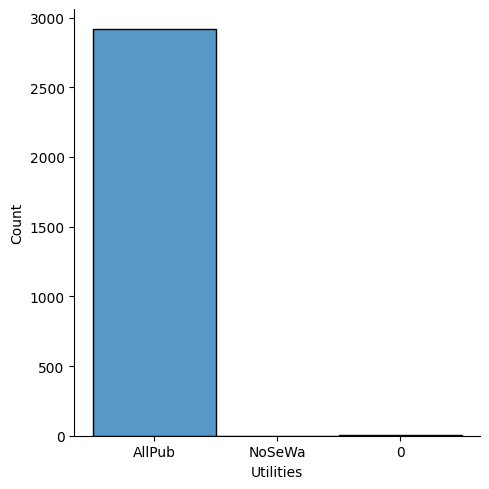

In [15]:
sns.displot(df_all['Utilities'])

In [16]:
# delete columns mostly same value
df_all = df_all.drop(['Utilities'], axis=1)

In [17]:
df_all['BsmtFullBath'] = df_all['BsmtFullBath'].fillna(0)

In [18]:
df_all.isnull().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotArea             0
Street              0
LotShape            0
LandContour         0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrArea          0
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual            0
BsmtCond            0
BsmtExposure        0
BsmtFinType1        0
BsmtFinSF1          0
BsmtFinType2        0
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        0
BsmtHalfBath        0
FullBath  

### transform string/category columns

In [19]:
# category encoders

# create dummies
onehot_encoder = ce.OneHotEncoder(cols=['CentralAir', 'Electrical', 'PavedDrive', 'SaleType', 'SaleCondition', 
                                        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                                        'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'])

df_all = onehot_encoder.fit_transform(df_all)

# to order variable
order_encoder = ce.OrdinalEncoder(cols=['LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', 
                                        'ExterQual', 'ExterCond', 
                                        'HeatingQC', 'KitchenQual', 'Functional'])

df_all = order_encoder.fit_transform(df_all)

# encode categories by count
count_encoder = ce.CountEncoder(cols=['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 
                                      'Neighborhood', 'Condition1', 'Condition2', 'RoofMatl', 'Foundation',
                                      'Heating', 'Exterior1st', 'Exterior2nd'])

df_all = count_encoder.fit_transform(df_all)

### Add some useful columns

In [20]:
df_all['YrBuiltRemodel'] = df_all['YearBuilt'] + df_all['YearRemodAdd']

df_all['TotalSF'] = df_all['TotalBsmtSF'] + df_all['1stFlrSF'] + df_all['2ndFlrSF']

df_all['TotalBath'] = (df_all['FullBath'] + (0.5 * df_all['HalfBath']) 
                       + df_all['BsmtFullBath'] + (0.5 * df_all['BsmtHalfBath']))

df_all['TotalPorchSF'] = (df_all['OpenPorchSF'] + df_all['3SsnPorch'] + df_all['EnclosedPorch'] 
                          + df_all['ScreenPorch'] + df_all['WoodDeckSF'])

## Data descriptive visualizations

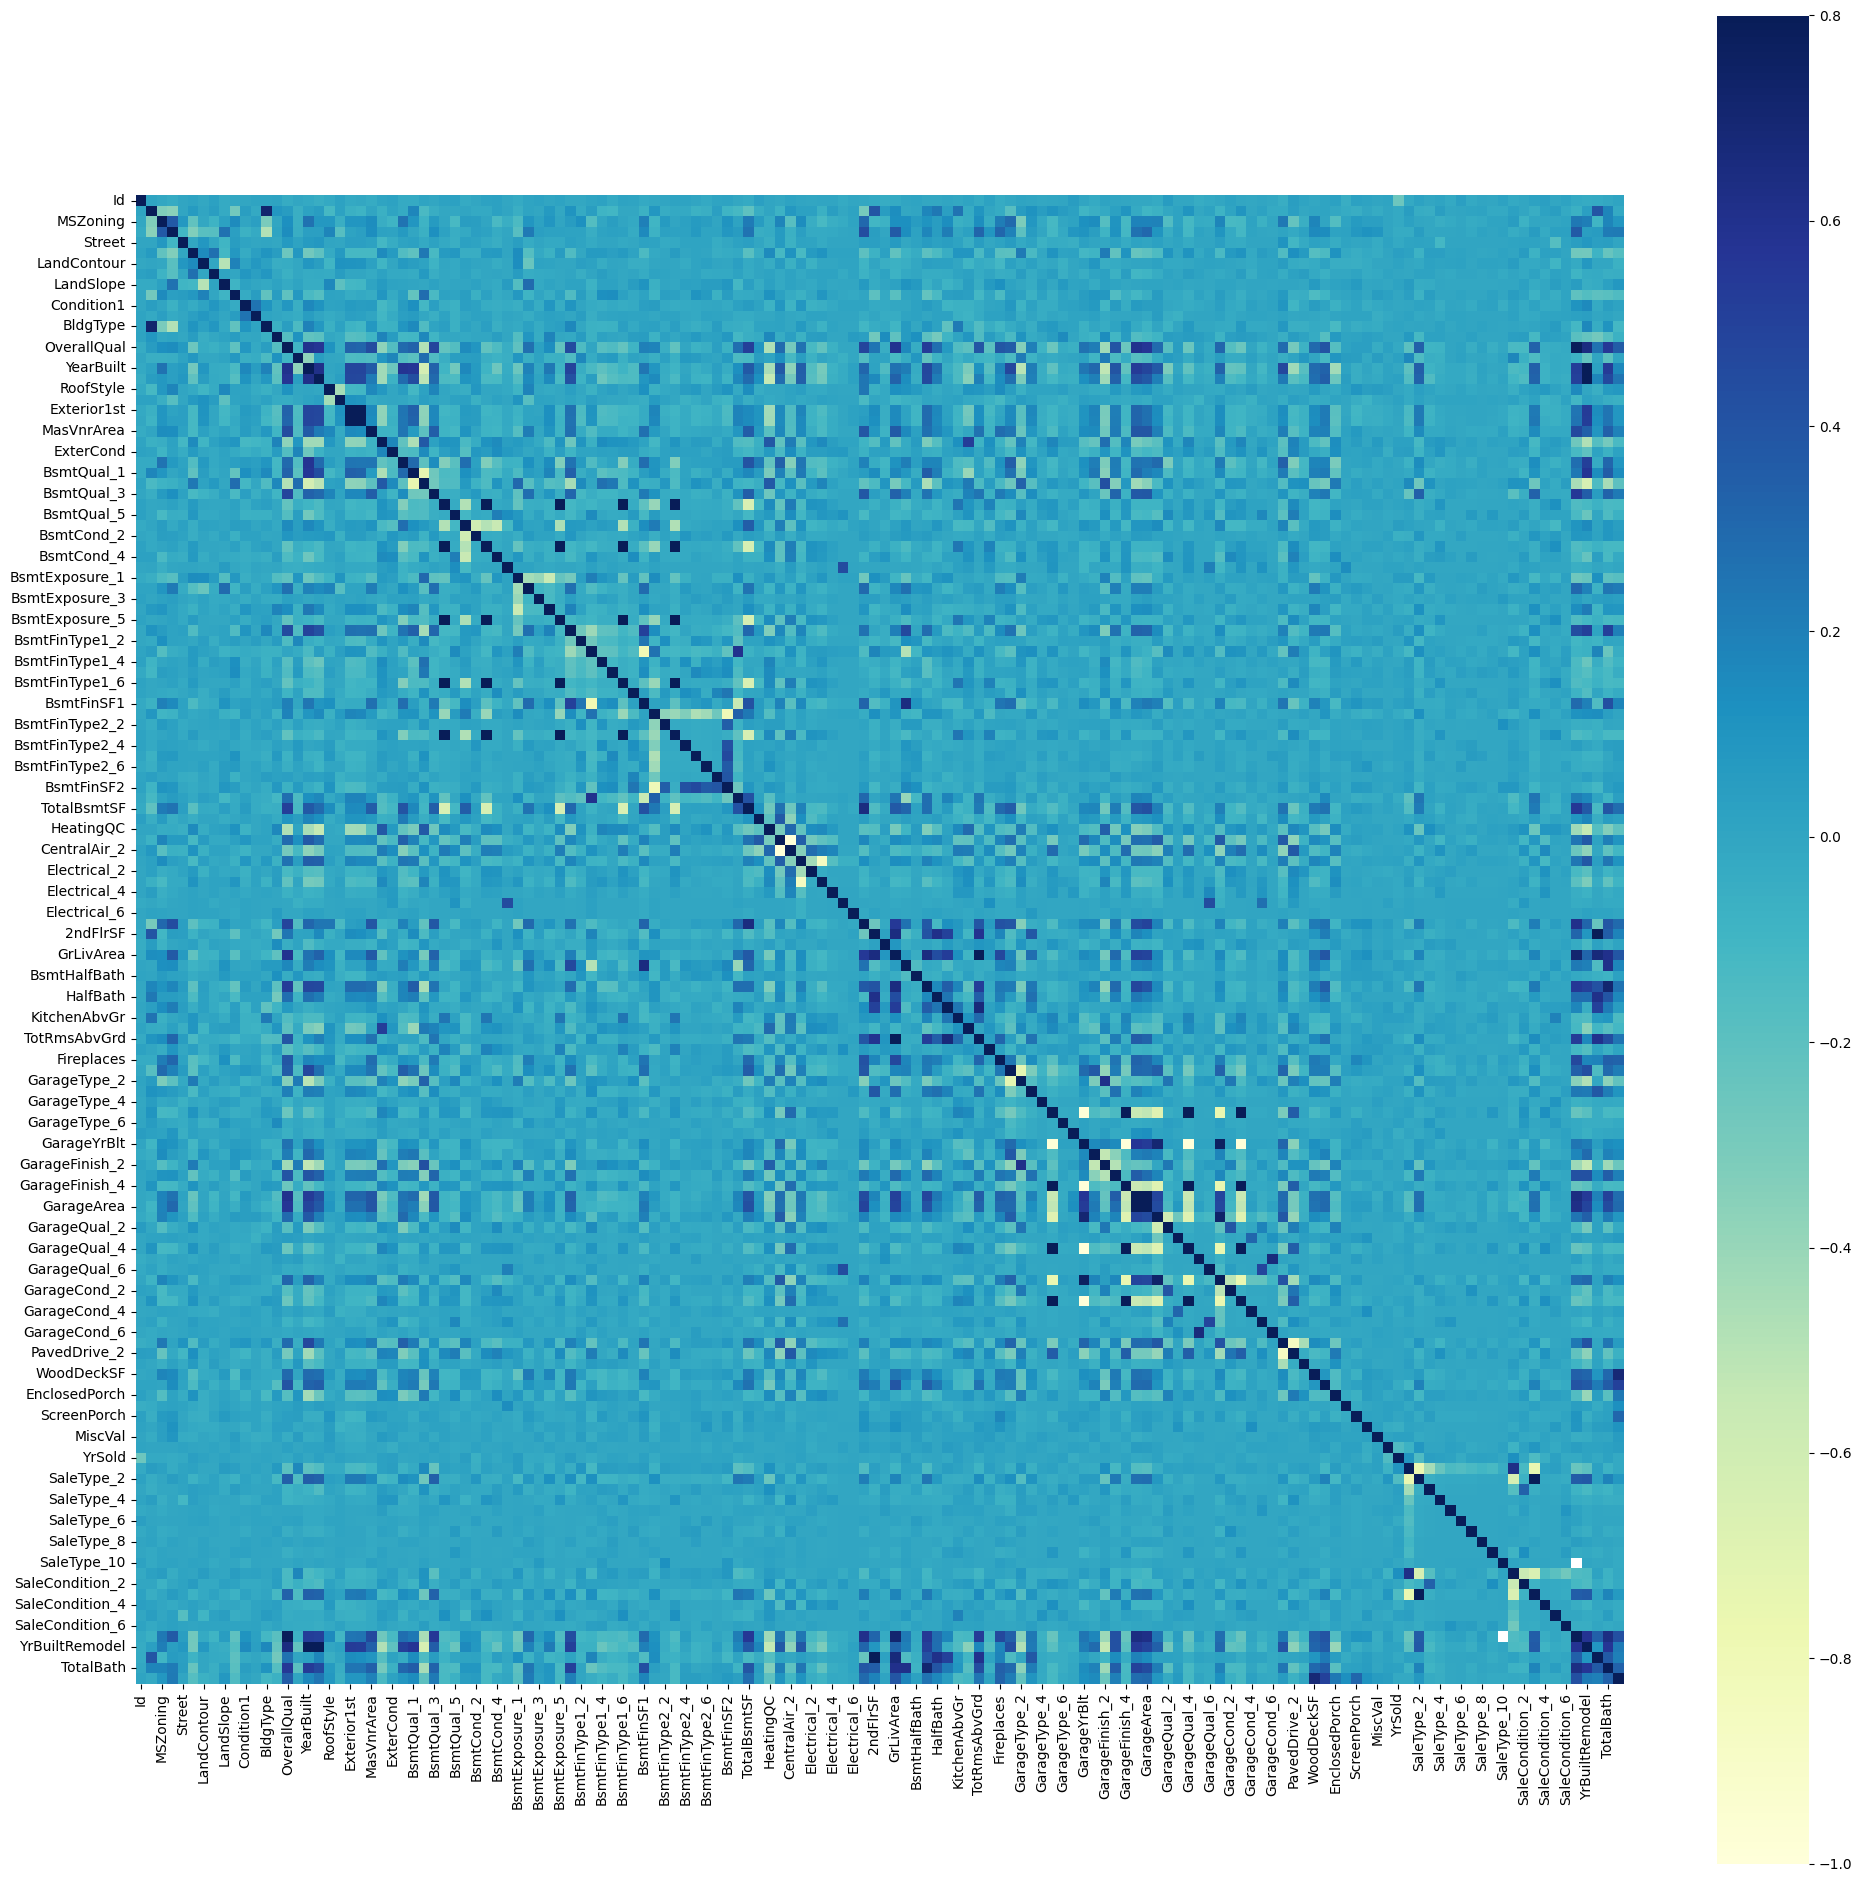

In [21]:
plt.figure(figsize=(24,24))
sns.heatmap(df_all.corr(), vmax=.8, square=True, cmap='YlGnBu');

### split dataframe into train/test

In [22]:
df_train_clean = df_all.loc[df_all['SalePrice'].notnull()]
df_test_clean = df_all.loc[df_all['SalePrice'].isnull()]

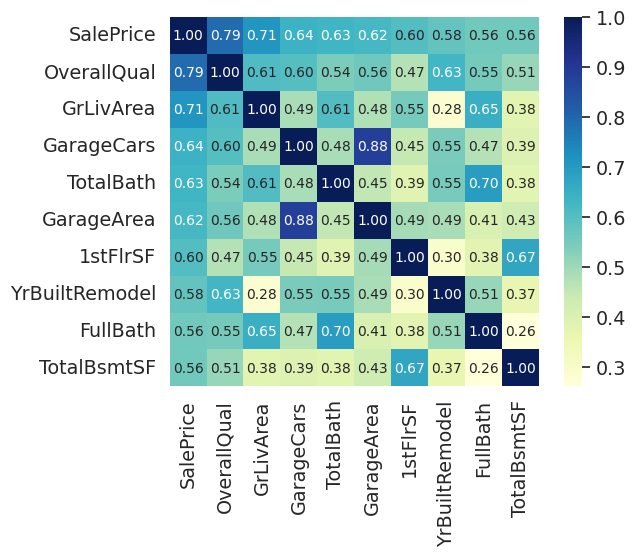

In [23]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = df_train_clean.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train_clean[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values, cmap='YlGnBu')
plt.show()

Consider drop GarageCars or GarageArea since they are highly correlate to each other.
Here, we keep GarageCars which shows higher correlation to SalePrice.

In [24]:
df_all = df_all.drop(['GarageArea'], axis=1)

In [25]:
df_train_clean = df_all.loc[df_all['SalePrice'].notnull()]
df_test_clean = df_all.loc[df_all['SalePrice'].isnull()]

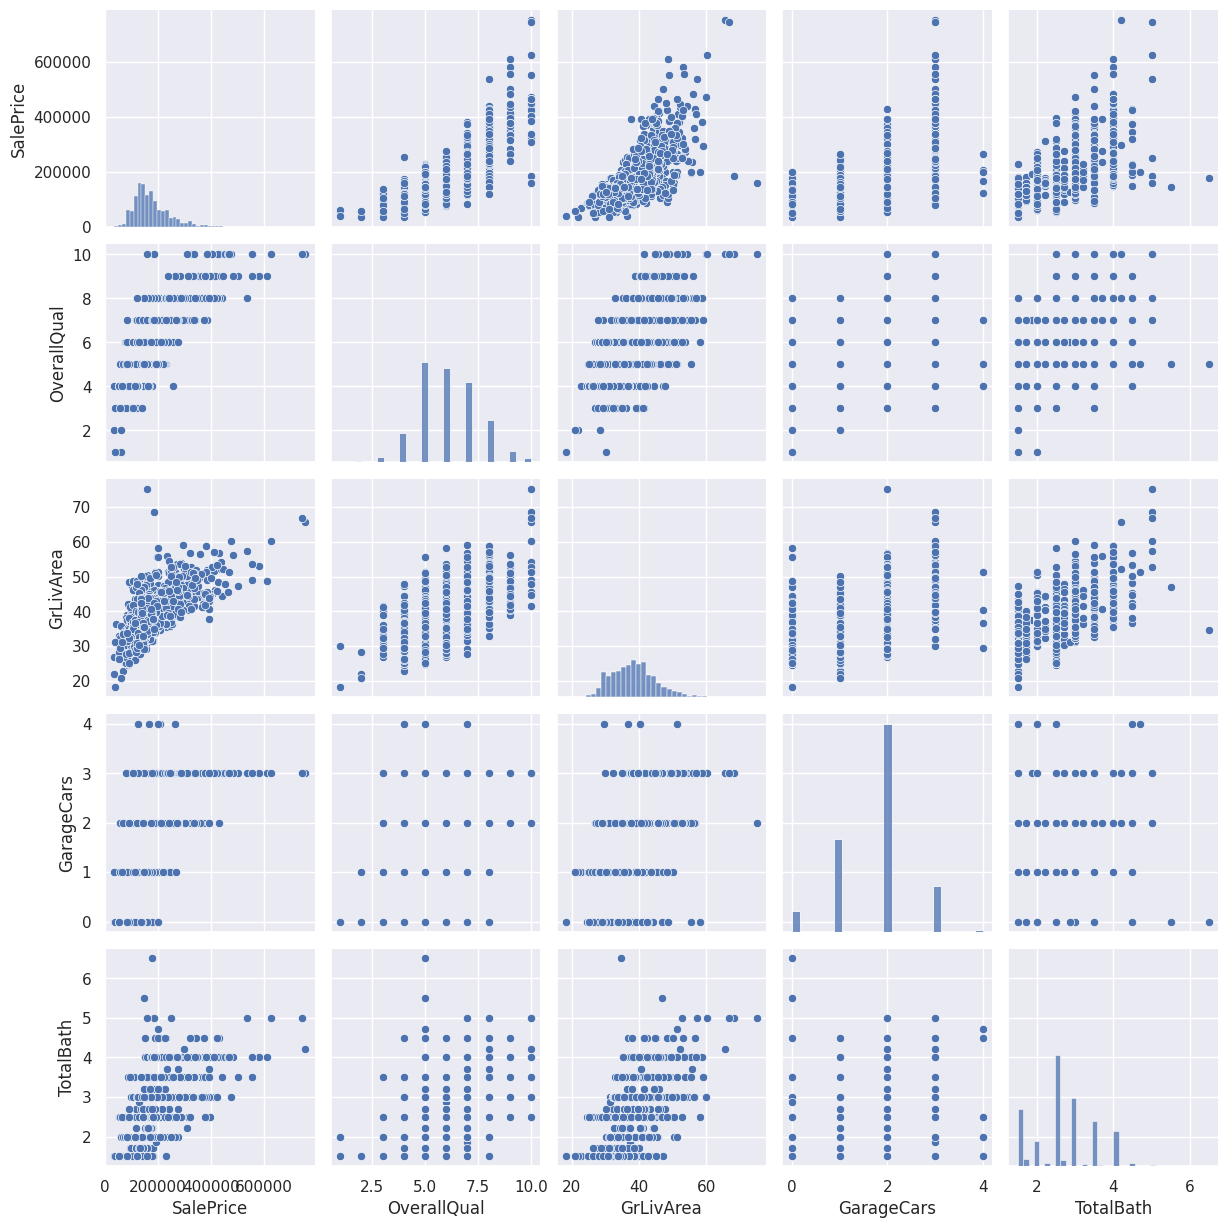

In [26]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBath']
sns.pairplot(df_train_clean[cols], height = 2.5)
plt.show();

## Training

### Split X, y

In [27]:
X = df_train_clean.drop(['SalePrice'], axis=1)
y = df_train_clean['SalePrice']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [29]:
# simplify output
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.linalg import LinAlgWarning

# ignore ConvergenceWarning, LinAlgWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', LinAlgWarning)

### Ridge

In [30]:
from sklearn.linear_model import Ridge

# model selection
from sklearn.model_selection import GridSearchCV

ridg = Ridge()

param_grid = {
    'alpha' : [0.01, 0.1, 0.5, 1, 1.5, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

grid_search = GridSearchCV(ridg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

best_ridg = grid_search.best_estimator_



In [31]:
best_ridg

Ridge(alpha=60)

In [32]:
print(best_ridg.score(X_test, y_test))

0.8716552001333229


### Lasso

In [33]:
from sklearn.linear_model import Lasso

# model selection
lass = Lasso()

param_grid = {
    'alpha' : [0.01, 0.1, 0.5, 1, 1.5, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

grid_search = GridSearchCV(lass, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

best_lass = grid_search.best_estimator_

In [34]:
best_lass

Lasso(alpha=100)

In [35]:
print(best_lass.score(X_test, y_test))

0.8702767130584993


### ElasticNet

In [36]:
from sklearn.linear_model import ElasticNet

# model selection
elas = ElasticNet(max_iter=100000)

param_grid = {
    'alpha' : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(elas, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

best_elas = grid_search.best_estimator_

In [37]:
best_elas

ElasticNet(alpha=0.7, l1_ratio=0.9, max_iter=100000)

In [38]:
print(best_elas.score(X_test, y_test))

0.871328424263804


ElasticNet shows better performance than ridge and lasso themself

### XGBRegressor

In [39]:
from xgboost import XGBRegressor

# model selection
xgbr = XGBRegressor(objective='reg:squarederror')

param_grid = {
    'eta' : [0.01, 0.03, 0.1],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'n_estimators': [30, 60, 90, 120, 150],
    'subsample': [0.8, 0.9, 1]
}

grid_search = GridSearchCV(xgbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

best_xgbr = grid_search.best_estimator_

In [40]:
best_xgbr.score(X_test, y_test)

0.8808202919224442

### Random Forest Regressor

In [41]:
# import Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# model selection
rfr = RandomForestRegressor()

param_grid = {
    'n_estimators': [60, 90, 120, 150],
    'max_depth': [7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [30, 60, 90, 120, 150]
}

grid_search = GridSearchCV(rfr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [30, 60, 90, 120, 150]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [42]:
best_rfr = grid_search.best_estimator_
best_rfr

RandomForestRegressor(max_depth=10, min_samples_leaf=2, n_estimators=60)

In [43]:
print(best_rfr.score(X_test, y_test))

0.8718870596830185


### GradientBoostingRegressor 

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

# model selection
gbr = GradientBoostingRegressor()

param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [30, 60, 90, 120, 150],
    'max_depth': [7, 8, 9, 10],
    'subsample': [0.8, 0.9, 1]
}

grid_search = GridSearchCV(gbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [7, 8, 9, 10],
                         'n_estimators': [30, 60, 90, 120, 150],
                         'subsample': [0.8, 0.9, 1]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [45]:
best_gbr = grid_search.best_estimator_

In [46]:
print(best_gbr.score(X_test, y_test))

0.8879476876771358


### LGBMRegressor

In [47]:
from lightgbm import LGBMRegressor

# model selection
lgbmr = GradientBoostingRegressor()

param_grid = {
    'learning_rate': [0.01, 0.03, 0.1],
    'n_estimators': [30, 90, 120, 150, 300],
    'subsample': [0.8, 0.9, 1],
    'max_depth': [7, 8, 9, 10]
}

grid_search = GridSearchCV(lgbmr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [7, 8, 9, 10],
                         'n_estimators': [30, 90, 120, 150, 300],
                         'subsample': [0.8, 0.9, 1]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [48]:
best_lgbmr = grid_search.best_estimator_

In [49]:
best_lgbmr.score(X_test, y_test)

0.8827225717333431

## Test data and submission

In [50]:
X_test_clean = df_test_clean.drop(['SalePrice'], axis=1)

### Blended model

In [51]:
blend_pred = 0.2*best_elas.predict(X_test_clean) + 0.2*best_rfr.predict(X_test_clean) + 0.2*best_xgbr.predict(X_test_clean) + 0.2*best_gbr.predict(X_test_clean) + 0.2*best_lgbmr.predict(X_test_clean)

In [52]:
blend_pred

array([113774.36510414, 153720.95161901, 184175.76776547, ...,
       163676.95667092, 123689.8034551 , 219566.88208243])

In [53]:
saleprice = pd.DataFrame(blend_pred, columns=['SalePrice'])
output = pd.concat([X_test_clean['Id'], saleprice['SalePrice']],axis=1)
output.head()

,Id,SalePrice
0,1461,113774.365104
1,1462,153720.951619
2,1463,184175.767765
3,1464,190878.590137
4,1465,181436.210325


In [54]:
output.to_csv('submission.csv', index = False)

### (maybe) transform built-year into category type
- GarageYrBlt
- YrSold
- MoSold
- BsmtUnfSF